# Dual-energy head CT calcium vs. hemorrhage data analysis

Set up the environment by importing the appropriate modules.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import warnings; warnings.simplefilter('ignore')

## 1. Quantitative analysis

### a) Determination of quantitative thresholds by maximizing the F1-score from ROC analysis with repeated K-fold cross-validation

Import quantitative ROI data and prepare for analysis.

In [3]:
df = pd.read_csv('./data/data.csv')

X_vnc = np.array(df.VNCa).reshape([-1, 1])
X_cm = np.array(df.CaM).reshape([-1, 1])
X_mix = np.array(df.Mixed).reshape([-1, 1])
X_both = np.array(df.loc[:, ['VNCa', 'CaM']])
Y = np.array(df.hemorrhage)


Define a function to perform the quantitative analysis in the following steps:

1. Split the data into train and test groups using K-fold cross-validation method with K = 5
2. Model the data using logistic regression
3. Calculate the ROC curve
4. Use the F1-score to determine the optimal threshold
5. Convert the thresholds to HU for mixed, VNCa and CaO values (stick with LogReg prediction thresholds for VNCa+CaO)
4. Repeat x100 to determine stability of ROC curves and optimal thresholds

Perform analysis under each condition (mixed, VNCa, etc.), print the thresholds, then plot the ROC curves.

In [4]:
from quant_roc import *

/Users/walterwiggins/miniconda3/envs/datasci/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [5]:
mix = QuantAnalysis(X_mix, Y)
mix.analyze()
print("Threshold for single-energy model: %d +/- %1.1f HU" % (mix.mean_thresh_hu, 1.96*mix.sem_thresh_hu))

vnc = QuantAnalysis(X_vnc, Y)
vnc.analyze()
print("Threshold for virtual noncalcium (VNCa) model: %d +/- %1.1f HU" % (vnc.mean_thresh_hu, 1.96*vnc.sem_thresh_hu))

cm = QuantAnalysis(X_cm, Y)
cm.analyze()
print("Threshold for calcium (Ca) model: %d +/- %1.1f HU" % (cm.mean_thresh_hu, 1.96*cm.sem_thresh_hu))

both = QuantAnalysis(X_both, Y)
both.analyze()
print("Threshold for VNCa + Ca model: %0.2f +/- %0.2f" % (both.mean_thresh, 1.96*both.sem_thresh))


Threshold for single-energy model: 74 +/- 0.6 HU
Threshold for virtual noncalcium (VNCa) model: 44 +/- 0.6 HU
Threshold for calcium (Ca) model: 7 +/- 0.4 HU
Threshold for VNCa + Ca model: 0.84 +/- 0.01


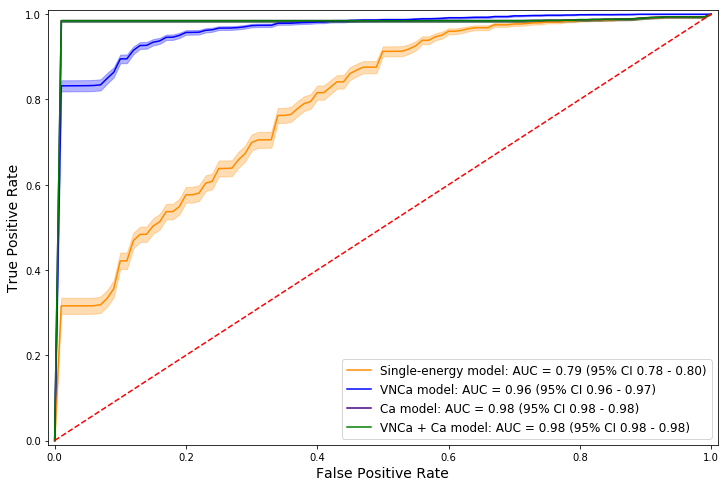

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# Single-energy model ROC curve
mix.plot_roc(ax, color='darkorange', label='Single-energy')
# VNCa model ROC curve
vnc.plot_roc(ax, color='blue', label='VNCa')
# Calcium model ROC curve
cm.plot_roc(ax, color='indigo', label='Ca')
# VNCa + Ca model ROC curve
both.plot_roc(ax, color='green', label='VNCa + Ca')
# Adjust plot settings and show
ax.plot([0, 1], [0, 1], 'r--')
ax.set_xlim([-0.01, 1.01])
ax.set_ylim([-0.01, 1.01])
ax.set_xlabel('False Positive Rate', fontdict={'size': 14})
ax.set_ylabel('True Positive Rate', fontdict={'size': 14})
# ax.title('ROC analysis for quantitative classification of hemorrhage')
ax.legend(loc='lower right', prop={'size': 12});
fig.savefig('../figs/Fig_1.png', dpi=300)


### b) Utilization of quantitative thresholds to determine diagnostic performance of ROI thresholds

Import the data set that includes indeterminate lesions to evaluate diagnostic performance of the threshold values (and LogReg model for VNCa+CaO values).

In [7]:
df = pd.read_csv('./data/data_w_indet.csv')

X_mix = np.array(df.Mixed).reshape([-1, 1])
X_vnc = np.array(df.VNCa).reshape([-1, 1])
X_cm = np.array(df.CaM).reshape([-1, 1])
X_both = np.array(df.loc[:, ['VNCa', 'CaM']])
y = np.array(df.hemorrhage)
indet = np.array(df.indeterminate)

Define a function to fit a logistic regression model to non-indeterminate lesions and then evaluate diagnostic performance on indeterminate lesions.

In [8]:
from performance import *

Perform analysis in each case, then print results.

In [9]:
mix_thresh = 74
mix_perf = PerformanceAnalysis(X_mix, y, indet, pos_ind='below')
mix_perf.analyze_by_thresh(mix_thresh)
mix_perf.sensitivity_analysis()
vnc_thresh = 44
vnc_perf = PerformanceAnalysis(X_vnc, y, indet)
vnc_perf.analyze_by_thresh(vnc_thresh)
vnc_perf.sensitivity_analysis()
cm_thresh = 7
cm_perf = PerformanceAnalysis(X_cm, y, indet, pos_ind='below')
cm_perf.analyze_by_thresh(cm_thresh)
cm_perf.sensitivity_analysis()
both_thresh = 0.84
both_perf = PerformanceAnalysis(X_both, y, indet)
both_perf.analyze_by_thresh(both_thresh)
both_perf.sensitivity_analysis()


In [10]:
mix_perf.print_performance(label='Single-energy')
vnc_perf.print_performance(label='VNCa')
cm_perf.print_performance(label='Ca')
both_perf.print_performance(label='VNCa + Ca')


Performance measures for Single-energy model at threshold 74 HU:
Sensitivity: 1.00 +/- 0.00
Specificity: 0.16 +/- 0.11
PPV: 0.43 +/- 0.15
NPV: 1.00 +/- 0.00
Accuracy: 0.49 +/- 0.15

Performance measures for VNCa model at threshold 44 HU:
Sensitivity: 0.88 +/- 0.10
Specificity: 0.88 +/- 0.10
PPV: 0.82 +/- 0.12
NPV: 0.92 +/- 0.08
Accuracy: 0.88 +/- 0.10

Performance measures for Ca model at threshold 7 HU:
Sensitivity: 0.88 +/- 0.10
Specificity: 1.00 +/- 0.00
PPV: 1.00 +/- 0.00
NPV: 0.93 +/- 0.08
Accuracy: 0.95 +/- 0.07

Performance measures for VNCa + Ca model at threshold 0.84 HU:
Sensitivity: 1.00 +/- 0.00
Specificity: 0.92 +/- 0.08
PPV: 0.89 +/- 0.10
NPV: 1.00 +/- 0.00
Accuracy: 0.95 +/- 0.07



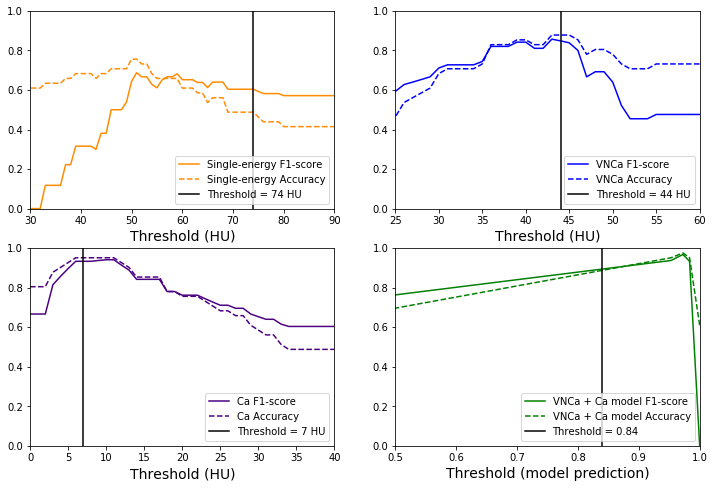

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
mix_perf.plot_sensitivity(ax[0, 0], label='Single-energy', color='darkorange', xlim=(30, 90))
vnc_perf.plot_sensitivity(ax[0, 1], label='VNCa', color='blue', xlim=(25, 60))
cm_perf.plot_sensitivity(ax[1, 0], label='Ca', color='indigo', xlim=(0, 40))
both_perf.plot_sensitivity(ax[1, 1], label='VNCa + Ca model', color='green', hu=False, xlim=(0.5, 1))
fig.savefig('../figs/Fig_sens_analysis.png', dpi=300)


## 2. Reader study analysis

Import data from reader study and drop columns that won't be used for analysis.

In [12]:
df = pd.read_csv('./data/reader_study_mod.csv')
df = df.drop(['ref_std', 'size'], axis=1).set_index('idx')
df.head(5)


,ref_truth,ca,hem,intrapar,mix_p,conf1_p,de_qual_p,conf2_p,de_final_p,conf3_p,...,de_qual_s,conf2_s,de_final_s,conf3_s,discrep_init,discrep_final,de_bad_p,de_bad_s,bad_switch_p,bad_switch_s
idx,,,,,,,,,,,,,,,,,,,,,
2,L tent Ca,1,0,0,ca,2,ca,2,ca,2,...,ca,2,ca,2,0,0,0,0,0,0
3,L tent Ca,1,0,0,ca,2,ca,2,ca,2,...,ca,2,ca,2,0,0,0,0,0,0
4,L BG Ca,1,0,1,ca,2,ca,2,ca,2,...,ca,2,ca,2,0,0,0,0,0,0
5,L tent Ca,1,0,0,ca,2,ca,2,ca,2,...,ca,2,ca,2,0,0,0,0,0,0
6,R frontal Ca mass,1,0,1,ca,2,ca,2,ca,2,...,ca,2,ca,2,0,0,0,0,0,0


Establish dedicated arrays with the reader scores of the mixed images and check to make sure they're the same size, then calculate the Cohen kappa score.

In [13]:
from reader_analysis import *
from statsmodels.stats.inter_rater import cohens_kappa

Challenging foci defined as...

At least one reader:
- Incorrect...OR
- Uncertain

...on Single-energy images

In [14]:
diag_chlng = df.where((df.mix_p != df.mix_s) | (df.conf1_p == 0) | (df.conf1_s == 0)).dropna()
print(f"Total in test set: {df.shape[0]}")
print(f"# of calcium: {df.ca.sum()}")
print(f"# of hemorrhage: {df.hem.sum()}")
print(f"# of intraparenchymal foci: {df.intrapar.sum()} / {df.shape[0]}")
print(f"# of challenging foci: {diag_chlng.shape[0]} / {df.shape[0]}")
diag_chlng[['ref_truth', 'mix_p', 'conf1_p', 'mix_s', 'conf1_s']]

Total in test set: 41
# of calcium: 25
# of hemorrhage: 16
# of intraparenchymal foci: 28 / 41
# of challenging foci: 11 / 41


,ref_truth,mix_p,conf1_p,mix_s,conf1_s
idx,,,,,
7,R pons Ca,ca,1.0,ca,0.0
13,Bilobed pericallosal mass - L Ca,ca,2.0,hem,0.0
16,L frontal SAH,ca,1.0,hem,0.0
18,L tent SDH,ca,1.0,hem,1.0
33,"Frontal parafalcine indet, Ca on f/u",hem,0.0,ca,0.0
38,L cerebellar met w/ intralesional hem,hem,1.0,hem,0.0
39,L subinsular intratumoral hemorrhage,hem,2.0,ca,0.0
40,L frontal SAH,hem,0.0,hem,2.0
46,L posterior temporal hemorrhagic met,hem,1.0,hem,0.0


In [15]:
filt = df.ca == 1
ca = df[filt]
print(ca.shape[0])
print(ca.intrapar.mean())

25
0.76


In [16]:
filt = df.hem == 1
hem = df[filt]
print(hem.shape[0])
print(hem.intrapar.mean())

16
0.5625


In [17]:
ktab = binary_kappa_table(df.mix_p, df.mix_s)
ktab

array([[22.,  5.],
       [ 2., 12.]])

In [18]:
k_mix = cohens_kappa(ktab)
print(f"Single-energy Cohen kappa: {k_mix['kappa']:.2f} (95% CI: {k_mix['kappa_low']:.2f} - {k_mix['kappa_upp']:.2f})")


Single-energy Cohen kappa: 0.64 (95% CI: 0.40 - 0.88)


Repeat the process for the qualitative and final DE reader scores.

In [19]:
ktab_2 = binary_kappa_table(df.de_qual_p, df.de_qual_s)
k_de1 = cohens_kappa(ktab_2)
print(f"DE-qualitative Cohen kappa: {k_de1['kappa']:.2f} (95% CI: {k_de1['kappa_low']:.2f} - {k_de1['kappa_upp']:.2f})")


DE-qualitative Cohen kappa: 1.00 (95% CI: 1.00 - 1.00)


In [20]:
ktab_2 = binary_kappa_table(df.de_final_p, df.de_final_s)
k_de2 = cohens_kappa(ktab_2)
print(f"DE-final Cohen kappa: {k_de2['kappa']:.2f} (95% CI: {k_de2['kappa_low']:.2f} - {k_de2['kappa_upp']:.2f})")


DE-final Cohen kappa: 1.00 (95% CI: 1.00 - 1.00)


Calculate accuracy on mixed images for each reader.

In [21]:
accs_p = reader_accuracy(df, 'mix_p')
acc_p = accs_p.mean()
acc_p_ci = exact_binomial_conf(acc_p, len(accs_p))
print(f'Reader 1 - Single-energy accuracy: {acc_p:.2f} +/- {acc_p_ci:.2f}')
print(accs_p.sum())
print(0.09 * 41)

Reader 1 - Single-energy accuracy: 0.90 +/- 0.09
37
3.69


In [22]:
accs_s = reader_accuracy(df, 'mix_s')
acc_s = accs_s.mean()
acc_s_ci = exact_binomial_conf(acc_s, len(accs_s))
print(f'Reader 2 - Single-energy accuracy: {acc_s:.2f} +/- {acc_s_ci:.2f}')
print(accs_s.sum())
print(0.08 * 41)

Reader 2 - Single-energy accuracy: 0.93 +/- 0.08
38
3.2800000000000002


Convert reader scores to a Likert scale by using the provided confidence values.

Likert scale | Interpretation
:---:|:---:
-2 | very likely Ca
-1 | probably Ca
0 | uncertain
1 | probably Hem
2 | very likely Hem


In [23]:
for i in df.index:
    if (df.loc[i, 'mix_p'] == "ca"):
        df.loc[i, 'likert_mix_p'] = -1 * df.loc[i, 'conf1_p']
    else:
        df.loc[i, 'likert_mix_p'] = 1 * df.loc[i, 'conf1_p']
        
    if (df.loc[i, 'mix_s'] == "ca"):
        df.loc[i, 'likert_mix_s'] = -1 * df.loc[i, 'conf1_s']
    else:
        df.loc[i, 'likert_mix_s'] = 1 * df.loc[i, 'conf1_s']
        
    if (df.loc[i, 'de_final_p'] == "ca"):
        df.loc[i, 'likert_de_final_p'] = -1 * df.loc[i, 'conf3_p']
    else:
        df.loc[i, 'likert_de_final_p'] = 1 * df.loc[i, 'conf3_p']
        
    if (df.loc[i, 'de_final_s'] == "ca"):
        df.loc[i, 'likert_de_final_s'] = -1 * df.loc[i, 'conf3_s']
    else:
        df.loc[i, 'likert_de_final_s'] = 1 * df.loc[i, 'conf3_s']

df.head(10)

,ref_truth,ca,hem,intrapar,mix_p,conf1_p,de_qual_p,conf2_p,de_final_p,conf3_p,...,discrep_init,discrep_final,de_bad_p,de_bad_s,bad_switch_p,bad_switch_s,likert_mix_p,likert_mix_s,likert_de_final_p,likert_de_final_s
idx,,,,,,,,,,,,,,,,,,,,,
2,L tent Ca,1,0,0,ca,2,ca,2,ca,2,...,0,0,0,0,0,0,-2.0,-2.0,-2.0,-2.0
3,L tent Ca,1,0,0,ca,2,ca,2,ca,2,...,0,0,0,0,0,0,-2.0,-2.0,-2.0,-2.0
4,L BG Ca,1,0,1,ca,2,ca,2,ca,2,...,0,0,0,0,0,0,-2.0,-2.0,-2.0,-2.0
5,L tent Ca,1,0,0,ca,2,ca,2,ca,2,...,0,0,0,0,0,0,-2.0,-2.0,-2.0,-2.0
6,R frontal Ca mass,1,0,1,ca,2,ca,2,ca,2,...,0,0,0,0,0,0,-2.0,-1.0,-2.0,-2.0
7,R pons Ca,1,0,1,ca,1,ca,1,ca,2,...,0,0,0,0,0,0,-1.0,0.0,-2.0,-2.0
9,L parietal Ca,1,0,1,ca,2,ca,2,ca,2,...,0,0,0,0,0,0,-2.0,-1.0,-2.0,-2.0
11,L BG Ca,1,0,1,ca,2,ca,2,ca,2,...,0,0,0,0,0,0,-2.0,-2.0,-2.0,-2.0
12,Parafalcine SDH,0,1,0,hem,2,hem,2,hem,2,...,0,0,0,0,0,0,2.0,2.0,2.0,1.0


Define a function to perform ROC analysis for each reader by computing the confusion matrix at each threshold on the Likert scale. 

* Inputs
    1. *assess*:  category of assessment - "mixed" or "de_final"
    2. *reader*:  "p" or "s"
* Output
    1. *tprs*:  true positive rates
    2. *fprs*:  false positive rates
    3. *auc*:  area-under-the-curve (AUC)

Perform the analysis for each reader and plot the ROC curves. Also plot the ROC curve for the "VNCa+CaO" logistic regression model for comparison.

In [24]:
tpr_mix_p, fpr_mix_p, auc_mix_p = roc_analysis(df, 'mix', 'p')
tpr_mix_s, fpr_mix_s, auc_mix_s = roc_analysis(df, 'mix', 's')
tpr_de_final_p, fpr_de_final_p, auc_de_final_p = roc_analysis(df, 'de_final', 'p')
tpr_de_final_s, fpr_de_final_s, auc_de_final_s = roc_analysis(df, 'de_final', 's')

/Users/walterwiggins/miniconda3/envs/datasci/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


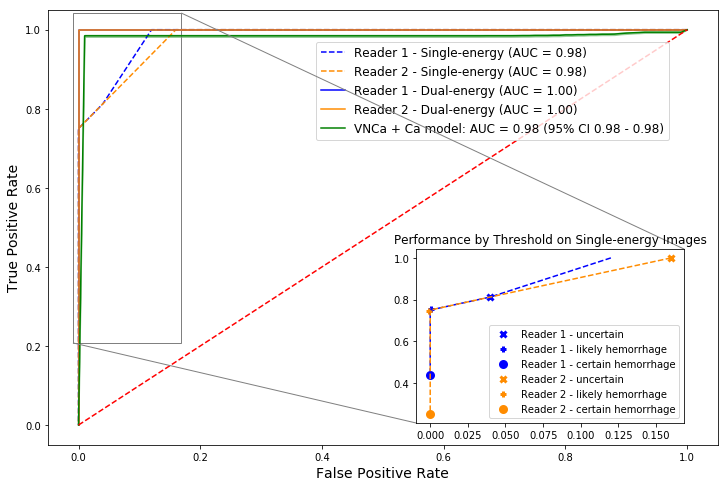

In [25]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes, InsetPosition, mark_inset

fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))
ax1.plot(fpr_mix_p, tpr_mix_p, linestyle='--', color='blue', label='Reader 1 - Single-energy (AUC = %0.2f)' % auc_mix_p)
ax1.plot(fpr_mix_s, tpr_mix_s, linestyle='--', color='darkorange', label='Reader 2 - Single-energy (AUC = %0.2f)' % auc_mix_s)
ax1.plot(fpr_de_final_p, tpr_de_final_p, color='blue', label='Reader 1 - Dual-energy (AUC = %0.2f)' % auc_de_final_p)
ax1.plot(fpr_de_final_s, tpr_de_final_s, color='darkorange', label='Reader 2 - Dual-energy (AUC = %0.2f)' % auc_de_final_s)
both.plot_roc(ax1, color='green', label='VNCa + Ca')
ax1.plot([0, 1], [0, 1], 'r--')
# ax1.xlim([-0.01, 1.01])
# ax1.ylim([-0.01, 1.01])
ax1.set_xlabel('False Positive Rate', fontdict={'size': 14})
ax1.set_ylabel('True Positive Rate', fontdict={'size': 14})
ax1.legend(loc=(0.40, 0.7), prop={'size': 12});

xjitter = 0.0005
yjitter = 0.005
ax2 = plt.axes([0, 0, 1, 1])
ip = InsetPosition(ax1, [0.55, 0.05, 0.4, 0.4])
ax2.set_axes_locator(ip)
mark_inset(ax1, ax2, loc1=1, loc2=3, fc="none", ec="0.5")
ax2.plot(fpr_mix_p[1:5], tpr_mix_p[1:5], linestyle='--', color='blue')
ax2.plot(fpr_mix_s[2:5], tpr_mix_s[2:5], linestyle='--', color='darkorange')
ax2.scatter(fpr_mix_p[2], tpr_mix_p[2], marker='x', linewidth=3, color='blue', label='Reader 1 - uncertain')
ax2.scatter(fpr_mix_p[3] + xjitter, tpr_mix_p[3] + yjitter, marker='+', linewidth=3, color='blue', label='Reader 1 - likely hemorrhage')
ax2.scatter(fpr_mix_p[4], tpr_mix_p[4], marker='o', linewidth=3, color='blue', label='Reader 1 - certain hemorrhage')
ax2.scatter(fpr_mix_s[2], tpr_mix_s[2], marker='x', linewidth=3, color='darkorange', label='Reader 2 - uncertain')
ax2.scatter(fpr_mix_s[3] - xjitter, tpr_mix_s[3] - yjitter, marker='+', linewidth=3, color='darkorange', label='Reader 2 - likely hemorrhage')
ax2.scatter(fpr_mix_s[4], tpr_mix_s[4], marker='o', linewidth=3, color='darkorange', label='Reader 2 - certain hemorrhage')
ax2.set_title('Performance by Threshold on Single-energy Images')
ax2.legend()

plt.show()
fig.savefig('../figs/Fig_3.png', dpi=300)

In [26]:
conf_p = ReaderConfidence(df, reader='p')
conf_p.analyze()
conf_s = ReaderConfidence(df, reader='s')
conf_s.analyze()


Reader #1 "certain" on Single-energy: 29/41 (71%, 95% CI: 23 - 35)
Reader #1 "certain" on Dual-energy: 37/41 (90%, 95% CI: 33 - 41)

Repeated Measures ANOVA results for Reader #1:
               Anova
       Num DF  Den DF F Value Pr > F
------------------------------------
series 1.0000 40.0000  5.9813 0.0190

Reader #2 "certain" on Single-energy: 19/41 (46%, 95% CI: 13 - 25)
Reader #2 "certain" on Dual-energy: 35/41 (85%, 95% CI: 31 - 39)

Repeated Measures ANOVA results for Reader #2:
               Anova
       Num DF  Den DF F Value Pr > F
------------------------------------
series 1.0000 40.0000 18.1560 0.0001



In [27]:
df1 = pd.DataFrame({'Confidence': df.conf1_p})
df1['Reader'] = 'Reader 1'
df1['Phase'] = 'Mixed'
df2 = pd.DataFrame({'Confidence': df.conf3_p})
df2['Reader'] = 'Reader 1'
df2['Phase'] = 'Dual-energy'
df3 = pd.DataFrame({'Confidence': df.conf1_s})
df3['Reader'] = 'Reader 2'
df3['Phase'] = 'Mixed'
df4 = pd.DataFrame({'Confidence': df.conf3_s})
df4['Reader'] = 'Reader 2'
df4['Phase'] = 'Dual-energy'
mix_combined = pd.concat([df1, df3])
de_combined = pd.concat([df2, df4])

In [28]:
mix_g = mix_combined.groupby(['Confidence', 'Reader'])['Phase'].count().unstack()
mix_g 

Reader,Reader 1,Reader 2
Confidence,,
0,2,8
1,10,14
2,29,19


In [29]:
r1 = np.array([2, 10, 29])
r1 = r1 / r1.sum()
r2 = np.array([8, 14, 19])
r2 = r2 / r2.sum()
conf = [0, 1, 2]
mix_df = pd.DataFrame({'Confidence': conf, 'Reader 1': r1, 'Reader 2': r2}).set_index('Confidence')
mix_df

,Reader 1,Reader 2
Confidence,,
0,0.048780,0.195122
1,0.243902,0.341463
2,0.707317,0.463415


In [30]:
de_g = de_combined.groupby(['Confidence', 'Reader'])['Phase'].count().unstack()
de_g

Reader,Reader 1,Reader 2
Confidence,,
1,4,6
2,37,35


In [31]:
r1 = np.array([0, 4, 37])
r1 = r1 / r1.sum()
r2 = np.array([0, 6, 35])
r2 = r2 / r2.sum()
conf = [0, 1, 2]
de_df = pd.DataFrame({'Confidence': conf, 'Reader 1': r1, 'Reader 2': r2}).set_index('Confidence')
de_df

,Reader 1,Reader 2
Confidence,,
0,0.000000,0.000000
1,0.097561,0.146341
2,0.902439,0.853659


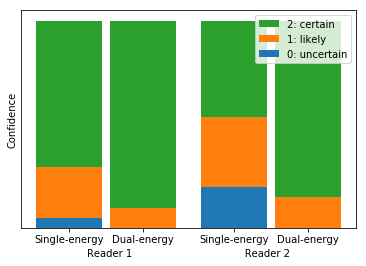

In [32]:
xs_mix = np.array([0.5, 1.5])
width = 0.4
xs_de = xs_mix + 0.45
fig, ax = plt.subplots()
ax.p1 = plt.bar(xs_mix, mix_df.loc[0, :], width)
ax.p2 = plt.bar(xs_mix, mix_df.loc[1, :], width, bottom=mix_df.loc[0, :])
ax.p3 = plt.bar(xs_mix, mix_df.loc[2, :], width, bottom=mix_df.loc[0, :]+mix_df.loc[1, :])
ax.p4 = plt.bar(xs_de, de_df.loc[0, :], width, color='C0')
ax.p5 = plt.bar(xs_de, de_df.loc[1, :], width, color='C1', bottom=de_df.loc[0, :])
ax.p6 = plt.bar(xs_de, de_df.loc[2, :], width, color='C2', bottom=de_df.loc[0, :]+de_df.loc[1, :])
plt.xticks([0.5, 0.95, 1.5, 1.95], ['Single-energy', 'Dual-energy', 'Single-energy', 'Dual-energy'])
plt.xlabel('Reader 1' + (' ')*36 + 'Reader 2')
plt.ylabel('Confidence')
plt.yticks([])
# plt.title('Reader confidence on Single-energy vs. dual-energy images')
plt.legend((ax.p6[0], ax.p5[0], ax.p4[0]), ('2: certain', '1: likely', '0: uncertain'),
           loc='upper right');
fig.savefig('../figs/Fig_reader_conf.png', dpi=300)
